# Baseline Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch
from torch.utils.data import DataLoader
import json
import math
from PIL import Image
import cv2
import plotly.graph_objects as go

## 1. Data Processing

### 1.1 Loading Images

In [2]:
def load_images_from_folder(folder):
    """
    Applies positional encoding to input coordinates by utilizing sine and cosine functions across multiple frequency bands.

    Inputs:
        p (torch.Tensor): Tensor containing coordinates of shape (h, w, d)
        L (int): Specifies the number of frequency bands.

    Output:
        torch.Tensor: A tensor with shape (h, w, d + 2 * d * L), incorporating the original coordinates and their encoded values at various frequencies.
    """
    
    images = []
    for filename in os.listdir(folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(folder, filename)
            try:
                img = Image.open(img_path)
                img = img.convert('RGB')  # Ensure 3 channels
                images.append(np.array(img))
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    return np.array(images)

In [3]:
# Define input paths
lego_train_folder = './data/nerf_synthetic/lego/train'
lego_val_folder = './data/nerf_synthetic/lego/val' 
lego_test_folder = './data/nerf_synthetic/lego/test' 

# Load images
train_images = load_images_from_folder(lego_train_folder)
if train_images.size == 0:
    raise ValueError("No images found in the train folder.")

val_images = load_images_from_folder(lego_val_folder)
if val_images.size == 0:
    raise ValueError("No images found in the val folder.")

test_images = load_images_from_folder(lego_test_folder)
if test_images.size == 0:
    raise ValueError("No images found in the val folder.")

H, W = train_images.shape[1:3]  # assume all images share the same width and height


In [4]:
print(train_images.shape) # 100 images of size 800x800 with 3 channels (RGB)
print(val_images.shape) # 100 images of size 800x800 with 3 channels (RGB)
print(test_images.shape) # 100 images of size 800x800 with 3 channels (RGB)

(100, 800, 800, 3)
(100, 800, 800, 3)
(600, 800, 800, 3)


### 1.3 Image Preprocessing

#### 1.3.1 Resize Images

In [5]:
# Function to resize images - https://github.com/akhilchibber/NeRF/blob/main/IMAGE_PRE_PROCESSING.py
def resize_images(images, target_size):
    """
    Applies positional encoding to input coordinates by utilizing sine and cosine functions across multiple frequency bands.

    Inputs:
        p (torch.Tensor): Tensor containing coordinates of shape (h, w, d)
        L (int): Specifies the number of frequency bands.

    Output:
        torch.Tensor: A tensor with shape (h, w, d + 2 * d * L), incorporating the original coordinates and their encoded values at various frequencies.
    """
    
    resized_images = []
    for img in images:
        img_pil = Image.fromarray(img)
        img_resized = img_pil.resize(target_size, Image.ANTIALIAS)
        resized_img = np.array(img_resized)
        resized_img = resized_img.astype(np.uint8)
        resized_images.append(resized_img)
    if len(resized_images) == 0:
        raise ValueError("No images to resize.")
    return np.stack(resized_images)

In [6]:
# Display original and example resized validation images for debugging
def display_images(original, resized):
    """
    Applies positional encoding to input coordinates by utilizing sine and cosine functions across multiple frequency bands.

    Inputs:
        p (torch.Tensor): Tensor containing coordinates of shape (h, w, d)
        L (int): Specifies the number of frequency bands.

    Output:
        torch.Tensor: A tensor with shape (h, w, d + 2 * d * L), incorporating the original coordinates and their encoded values at various frequencies.
    """
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(original)
    axes[0].set_title('Original Image')
    axes[1].imshow(resized)
    axes[1].set_title(f'Resized Image to {resized.shape[:2]}')
    plt.show()

C:\Users\mihai\AppData\Local\Temp\ipykernel_17940\2360156705.py:17: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img_resized = img_pil.resize(target_size, Image.ANTIALIAS)


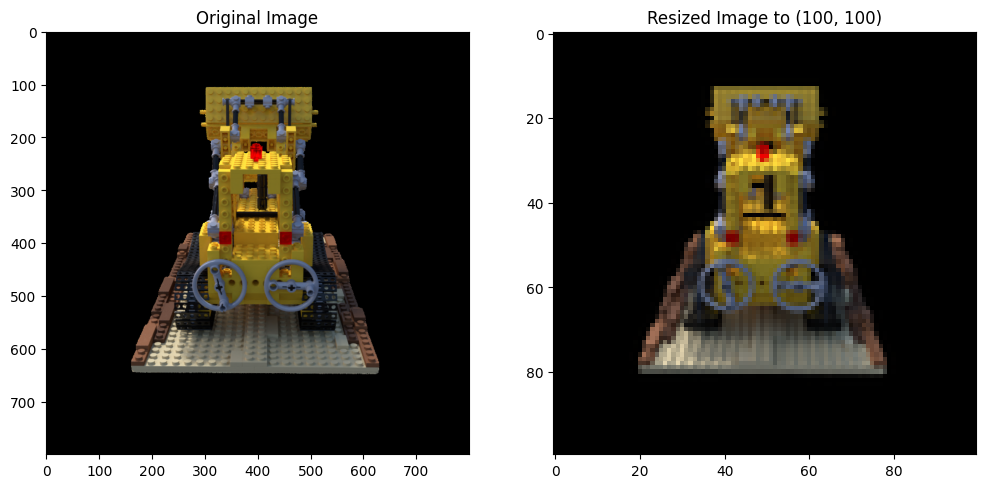

In [7]:
resized_train_images = resize_images(train_images, (100, 100))
val_images = resize_images(val_images, (100, 100))
test_images = resize_images(test_images, (100, 100))

display_images(train_images[0], resized_train_images[0])
train_images = resized_train_images
num_of_train_images, H, W, chanels = resized_train_images.shape


#### 1.3.2 Camera Parameters

In [8]:
# Open file with camera data - in read mode
with open('./data/nerf_synthetic/lego/transforms_train.json', 'r') as f:
    data = json.load(f)

# Given camera_angle_x (in radians) and image width W (in pixels)
camera_angle_x = data['camera_angle_x']

# Calculate the focal length
focal = W / (2 * math.tan(camera_angle_x / 2))

focal


138.88887889922103

In [9]:
# Open file with camera data - in read mode
with open('./data/nerf_synthetic/lego/transforms_train.json', 'r') as f:
    data = json.load(f)

# Extract the transform matrix for each frame
# Extract the transform matrices and convert them to tensors
poses = [] #poses represents the camera to world matrix
for frame in data['frames']:
    transform_matrix = np.array(frame['transform_matrix'], dtype=np.float32)
    poses.append(transform_matrix)

# Stack all the matrices into a single tensor
train_poses = np.stack(poses)

In [10]:
# Open file with camera data - in read mode
with open('./data/nerf_synthetic/lego/transforms_val.json', 'r') as f:
    data = json.load(f)

# Extract the transform matrix for each frame
# Extract the transform matrices and convert them to tensors
poses = [] #poses represents the camera to world matrix
for frame in data['frames']:
    transform_matrix = np.array(frame['transform_matrix'], dtype=np.float32)
    poses.append(transform_matrix)

# Stack all the matrices into a single tensor
val_poses = np.stack(poses)

In [11]:
# Open file with camera data - in read mode
with open('./data/nerf_synthetic/lego/transforms_test.json', 'r') as f:
    data = json.load(f)

# Extract the transform matrix for each frame
# Extract the transform matrices and convert them to tensors
poses = [] #poses represents the camera to world matrix
for frame in data['frames']:
    transform_matrix = np.array(frame['transform_matrix'], dtype=np.float32)
    poses.append(transform_matrix)

# Stack all the matrices into a single tensor
test_poses = np.stack(poses)
test_poses

array([[[-9.9999994e-01,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00, -7.3411000e-01,  6.7903060e-01,  2.7372601e+00],
        [ 0.0000000e+00,  6.7903066e-01,  7.3410988e-01,  2.9592917e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],

       [[-9.9802667e-01,  4.6095148e-02, -4.2636689e-02, -1.7187399e-01],
        [-6.2790513e-02, -7.3266143e-01,  6.7769074e-01,  2.7318587e+00],
        [-3.7252896e-09,  6.7903066e-01,  7.3410994e-01,  2.9592917e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],

       [[-9.9211472e-01,  9.1993682e-02, -8.5120998e-02, -3.4313372e-01],
        [-1.2533323e-01, -7.2820497e-01,  6.7380208e-01,  2.7161829e+00],
        [ 0.0000000e+00,  6.7915744e-01,  7.3399270e-01,  2.9588192e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],

       ...,

       [[-9.8228788e-01, -1.3720389e-01,  1.2761407e-01,  5.1442873e-01],
        [ 1.8737729

## 2. Positional Encoding

In [12]:
def positional_encoding(p, L):
    """
    Applies positional encoding to input coordinates by utilizing sine and cosine functions across multiple frequency bands.

     Arguments:
        p (torch.Tensor): Tensor containing coordinates of shape (h, w, d)
        L (int): Specifies the number of frequency bands.

    Output:
        torch.Tensor: A tensor with shape (h, w, d + 2 * d * L), incorporating the original coordinates and their encoded values at various frequencies.
    """

    # Generate exponents 0, 1, 2, ..., L - 1
    exponents = torch.linspace(0, L - 1, L).float()

    # Compute 2 raised to the power of each element
    freq = torch.pow(2, exponents).to(p.device)

    # Expand dimensions of p and L to prepare for multiplication with frequency bands
    p_expanded = p.unsqueeze(2)  # Shape: [h, w, 1, d]
    freq_expanded = freq.view(1, 1, L, 1)  # Shape: [1, 1, L, 1]

    # Multiply input by frequencies, scaling by pi for both sin and cos using torch.multiply
    x = p_expanded * freq_expanded * torch.pi

    # Compute sin and cos
    f_sin = torch.sin(x)
    f_cos = torch.cos(x)

    # Merge sin and cos tensors along the frequency axis
    output = torch.cat((f_sin, f_cos), dim=2)  # Shape: [h, w, 2 * L, d]

    # Flatten the frequency and dimension axes into a single axis
    output = output.view(p.shape[0], p.shape[1], -1)  # Shape: [h, w, 2 * L * d]

    # Append the encoded values to the original coordinates
    output = torch.cat((p, output), dim=-1)  # Shape: [h, w, d + 2 * d * L]

    return output

## 3. Ray Casting

In [13]:
def ray_casting(height, width, focal, c2w):
    i, j = np.meshgrid(np.arange(width), np.arange(height), indexing='xy')
    
    x = (i - width * 0.5) / focal
    y = -(j - height * 0.5) / focal
    z = -np.ones_like(i)
    directions = np.stack([x, y, z], axis=-1)
    
    dir_rays = np.einsum('ij,hwj->hwi', c2w[:3, :3], directions)
    origin_rays = np.broadcast_to(c2w[:3, 3], dir_rays.shape)
    
    return np.stack([origin_rays, dir_rays], axis=0)

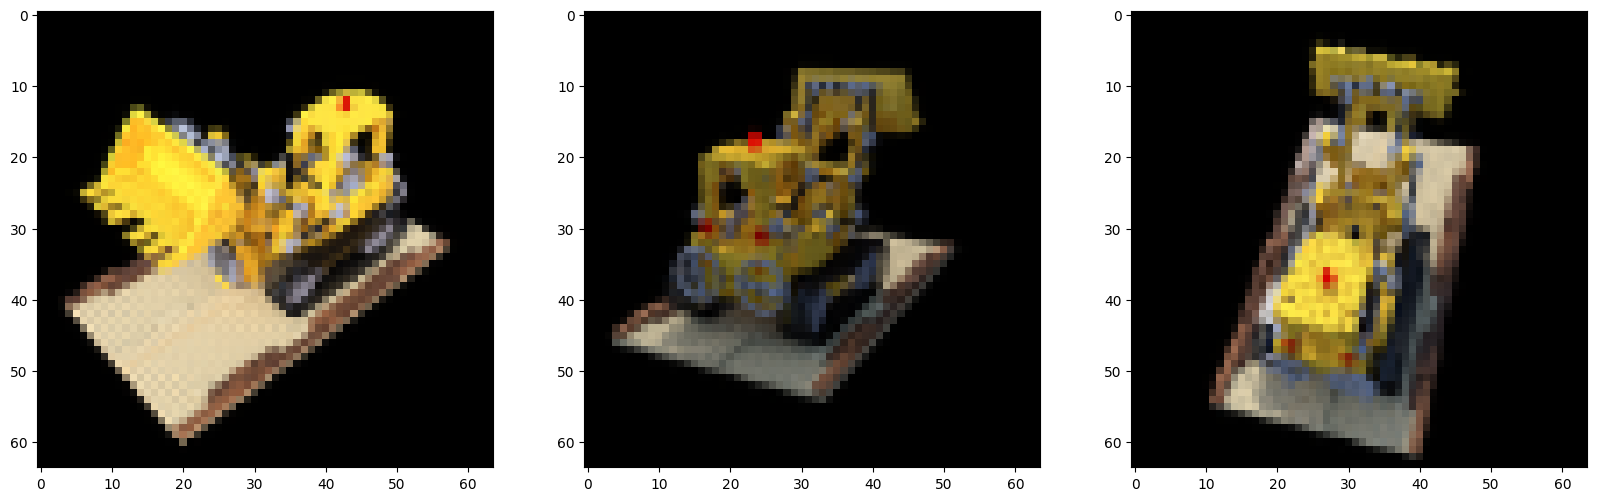

In [14]:
imgs_resized = []
random_idx = np.random.choice(np.arange(len(train_images)), 20, replace=False)

for index in random_idx:
    img = train_images[index]
    resized_img = cv2.resize(img, (64, 64))
    imgs_resized.append(resized_img)

imgs_resized = np.array(imgs_resized)

plt.figure(figsize=(20, 20))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(imgs_resized[i])

In [15]:
def visualize_rays(origin_rays, position_rays, RGBS=None):
    ray_lines = []

    for ray_origin, ray_position in zip(origin_rays, position_rays):
        ray_lines.append(ray_origin)
        ray_lines.append(ray_position)

    ray_lines = np.array(ray_lines)

    if RGBS is not None:
        colors = []

        for RGB in RGBS:
            colors.append(RGB)
            colors.append(RGB)

        colors = np.array(colors)
    else:
        colors = None

    ray_figure = go.Figure(
        data=go.Scatter3d(
            x=ray_lines[:, 1],
            y=ray_lines[:, 0],
            z=ray_lines[:, 2],
            marker=dict(size=3, color=colors),
            line=dict(color="lightgreen", width=0.25)
        )
    )

    ray_figure.update_layout(
        scene=dict(
            xaxis=dict(title="X"),
            yaxis=dict(title="Z"),
            zaxis=dict(title="Y")
        ),
    )


    return ray_figure


In [16]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [19]:
# works on google colab but not on vscode and idk why

# ray_samples = []
# for pose in poses[random_indices]:
#     rays = ray_casting(64, 64, focal*64/100, pose)
#     ray_samples.append(rays)

# ray_samples = np.array(ray_samples)

# sampled_ray_origins = np.reshape(ray_samples[:, 0, ...], (-1, 3))
# sampled_ray_directions = np.reshape(ray_samples[:, 1, ...], (-1, 3))

# rgb_sample = np.reshape(imgs_resized, (-1, 3))

# further_sampled_indices = np.random.choice(
#     np.arange(rgb_sample.shape[0]),
#     2000, 
#     replace=False)

# pixel_unproject_3d_positions = sampled_ray_origins + sampled_ray_directions

# visualize_rays(
#     sampled_ray_origins[further_sampled_indices],
#     pixel_unproject_3d_positions[further_sampled_indices],
#     rgb_sample[further_sampled_indices])


def render_rays(
    model, num_freq_bands, rays, near, far, N_samples, rand=False):
    # super long comments...
    """
    Renders an image from 3D rays by first uniformly sampling points along each
    ray, encoding these points using positional encoding, and then computing the
    predicted color and opacity at each point using the given MLP model.

    Args:
    model (nn.Module): MLP model that takes encoded 3D points as input and
            returns the predicted color and opacity.
    num_freq_bands (int): Number of frequency bands used for positional encoding.
    rays (Tuple[torch.Tensor, torch.Tensor]): Tuple containing origin and
        direction of the rays. Both tensors are of shape (num_rays, 3).
    near (float): Near clipping plane distance.
    far (float): Far clipping plane distance.
    N_samples (int): Number of samples along each ray.
    rand (bool): Boolean indicating whether to add random noise to jitter training points.

    Returns:
    Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: A tuple containing:
    - rgb_map (torch.Tensor): Tensor of shape (num_rays, 3)
          containing the predicted RGB color for each pixel in the image.
    - depth_map (torch.Tensor): Tensor of shape (num_rays, )
          containing the predicted depth for each pixel in the image.
    - acc_map (torch.Tensor): Tensor of shape (num_rays,)
          containing the accumulated alpha (transmittance) for each pixel in the image.
    """
    rays_o, rays_d = rays
    # uniformly sample points in the space from near to far.
    interpolations = torch.linspace(
        near, far, N_samples, device=rays_o.device).repeat(rays_o.shape[0], 1)
    if rand:
        # add random noise to jitter training points
        interpolations += (torch.rand(
            list(rays_o.shape[:-1]) + [N_samples], device=rays_o.device)
                  * (far-near)/N_samples) # we need to scale the noise accordingly

    # sampled pts in 3D space
    pts = rays_o[...,None,:] + rays_d[...,None,:] * interpolations[...,:,None]
    pts_flat = torch.reshape(pts, [-1,3])

    # Apply positional encoding to pts_flat
    pts_flat_freq_encoded = positional_encoding(pts_flat, num_freq_bands).float()
    raw = model(pts_flat_freq_encoded)
    raw = torch.reshape(raw, list(pts.shape[:-1]) + [4])

    # Compute opacities/occupancy and colors
    rgb, sigma_a = raw[...,:3], raw[...,3]
    sigma_a = torch.nn.functional.relu(sigma_a)
    rgb = torch.sigmoid(rgb)

    #Cite: https://medium.com/@ibrahim.farhat.co/understanding-nerf-on-a-small-scale-26a826b113ab
    # Do volume rendering
    # delta
    dists = torch.cat([interpolations[..., 1:] - interpolations[..., :-1],
                       torch.full_like(interpolations[...,:1], 1e10, device=rays_o.device)], -1)
    # alpha
    alpha = 1.-torch.exp(-sigma_a * dists)
    # transmittance
    trans = torch.where(1 - alpha > 1., 1., 1.-alpha + 1e-10)
    trans = torch.cat([torch.ones_like(trans[...,:1]), trans[...,:-1]], -1)
    # weights
    weights = alpha * torch.cumprod(trans, -1)

    rgb_map = torch.sum(weights[...,None] * rgb, -2)
    acc_map = torch.sum(weights, -1)
    depth_map = torch.sum(weights * interpolations, -1)
    return rgb_map, depth_map, acc_map



TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
#Simple MLP model
import torch
import torch.nn as nn

class baselineNeRF(nn.Module):
    def __init__(self, in_dim, net_dim, num_layers):
        super(baselineNeRF, self).__init__()
        

## 4. Training Code

In [ ]:
# code from https://gist.github.com/ihoromi4/b681a9088f348942b01711f251e5f964#file-seed_everything-py
def seed_everything(seed: int):
    import os
    import random

    import numpy as np
    import torch
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [ ]:
def train_nerf_model(
  model, optimizer, criterion, iters, train_data, device,
  num_freq_bands=8, batch_size=1024, near=2., far=6., N_samples=64):
  '''
  Trains a Neural Radiance Fields (NeRF) model on a given dataset. 
  The function uses batching/chunks to handle large amounts of data that cannot fit into GPU memory all at once.
  The function also uses MSE and PSNR (as used in Chang et Al's NerF Paper) to evaluate the accuracy of the training. 

  Here's a detailed explanation of the relevant code snippet:

  Arguments:
    model (torch.nn.Module): Neural network model to be trained.
    optimizer (torch.optim.Optimizer): Optimization algorithm for updating the model's parameters.
    criterion (torch.nn.Module): Loss function to compute the error between predictions and ground truth.
    iters (int): Number of training iterations.
    train_data (torch.Tensor): Training dataset containing rays and corresponding target values.
    device (torch.device): Device (CPU or GPU) to perform computations on.
    num_freq_bands (int, optional): Number of frequency bands used for positional encoding (default: 8).
    batch_size (int, optional): Number of rays to process in each training batch (default: 1024).
    near (float): Near bound of the scene for ray sampling (default: 2.0).
    far (float): Far bound of the scene for ray sampling (default: 6.0).
    N_samples (int): Number of samples

  Returns:
    tuple: Tensors containing the RGB values, depth, and accumulated transmittance after processing.
  '''

  seed_everything(0)

  batch_ind = 0 #batch index
  psnrs, mses, num_iter = [], [], []
  t = time.time()
  num_chunks = 5

  def batchify(rays, num_chunks):
    ray_chunks = torch.chunk(rays, num_chunks, dim=1)
    for k in range(num_chunks):
      #model, num_freq_bands, rays, near, far, N_samples, rand=False):
      rgb_chunk, depth_chunk, acc_chunk = render_rays(model, num_freq_bands, ray_chunks[k].to(device), near, far, N_samples, rand=False)
      # Merge the results from each chunk back together
      if k != 0:
        rgb, depth, acc = torch.cat((rgb, rgb_chunk), dim=0), torch.cat((depth, depth_chunk), dim=0), torch.cat((acc, acc_chunk), dim=0)
      else:
        rgb, depth, acc = rgb_chunk, depth_chunk, acc_chunk
    return rgb, depth, acc

  def define_rays():
    # Render the holdout view for logging
    # use global variables here
    rays = torch.tensor(get_rays(H, W, focal, poses[v,...])).reshape(2, -1, 3)

    # Use the batchified function
    rgb, depth, acc =batchify(rays,num_chunks=5)
    rgb, depth, acc = rgb.reshape(100, 100, 3), depth.reshape(100, 100, 1), acc.reshape(100, 100, 1)
    return rgb, depth, acc

  for i in range(iters):
    # iterate data
    batch = training_data[batch_ind: batch_ind + batch_size]
    batch_ind += batch_size
    rays = torch.moveaxis(torch.tensor(batch[:, :2]).to(device), 1, 0)
    target = torch.tensor(batch[:, 2]).to(device)
    if batch_ind > training_data.shape[0]:
      batch_ind = 0

    # Reset the gradients of the optimizer
    optimizer.zero_grad()
    # Forward pass through the model to obtain predictions
    rgb_map, depth_map, acc_map = render_rays(model, num_freq_bands, rays, near, far, N_samples, rand=True)
    # Compute the loss between the predictions and the training data
    loss = criterion(rgb_map, target)

    # Backward pass through the model to compute gradients
    loss.backward()

    # Update the model parameters using the optimizer
    optimizer.step()

    # Every 1000 iterations, compute and store the training and testing PSNRs,
    if i % 1000 == 0 or i == iters:
      model.eval()
      with torch.no_grad():
        psnr = []
        mse_list=[]
        # use global training poses here
        num_vals = poses.shape[0] if i == iters else 1
        for v in range(num_vals):
          rgb, depth, acc = define_rays()

          loss = criterion(rgb, torch.tensor(images[v,...], device=device))

          psnr.append(-10. * torch.log10(loss))

          mse_loss=criterion(rgb, torch.tensor(images[v, ...], device=device))
          mse_list.append(mse_loss.item())

          print(i, (time.time() - t), 'secs per 1000 iters', 'psnr:', psnr[-1])
          t = time.time()

          psnr = torch.mean(torch.tensor(psnr))
          psnrs.append(psnr)

          mse = torch.mean(torch.tensor(mse_list))
          mses.append(mse)

          num_iter.append(i)
          print(f"mse:{mse}, psnrs:{psnr}")

        model.train()

      #plot results
      plt.figure(figsize=(10,4))
      plt.subplot(121)
      plt.imshow(rgb.cpu().numpy())
      #tensor rgb is in gpu, plt.imshow expects a numpy array, which resides in cpu main memory
      plt.title(f'Iteration: {i}')
      plt.subplot(122)
      plt.plot(num_iter, psnrs)
      plt.title('PSNR')
      plt.show()

      plt.title(f'Iteration: {i}')
      plt.subplot(122)
      plt.plot(num_iter, mses)
      plt.title('MSE')
      plt.show()

  # Return the training and testing results as a dictionary
  return {
    'psnrs': psnrs,
    'mses': mses,
    'num_iter': num_iter,
  }


In [ ]:
#make_grid function
import numpy as np

def make_grid(img_shape):
    '''
    Generate a grid of pixel coordinates normalized to the unit square for a specified image shape.

    Args:
        img_shape (tuple): Dimensions of the image in the form (height, width, number of channels).

    Returns:
        numpy.ndarray: A (height, width, 2) array containing the x and y coordinates of each pixel normalized to the unit square.
    '''

    height, width, _ = img_shape
    
    # Create 1D arrays of x and y coordinates
    x = np.linspace(0, 1, width)
    y = np.linspace(0, 1, height)
    
    # Use broadcasting to create a grid of coordinates as opposed to meshgrid and stacking
    grid = np.zeros((height, width, 2))
    grid[..., 0] = x  # Assign x coordinates to the first channel
    grid[..., 1] = y[:, np.newaxis]  # Assign y coordinates to the second channel
    
    return grid



In [ ]:
def vis_camera_rays(rays_o, positions, rgbs=None):
    '''
    Visualizes camera rays as 3D lines between their origins and corresponding positions.

    Args:
        rays_o (numpy.ndarray): Array of shape (N, 3) representing origins of N camera rays.
        positions (numpy.ndarray): Array of shape (N, 3) representing positions corresponding to the ends of the rays.
        rgbs (numpy.ndarray, optional): Array of shape (N, 3) representing RGB colors for each ray. Defaults to None.

    Returns:
        plotly.graph_objs._figure.Figure: A Plotly Figure object containing a 3D scatter plot
        of the camera rays as lines with optional RGB coloring.
    '''
    num_rays = rays_o.shape[0]

    # Combine rays origin and positions into lines array
    lines = np.vstack((rays_o, positions)).reshape(2, num_rays, 3).transpose(1, 0, 2).reshape(-1, 3)
    
    # Handle colors if provided
    if rgbs is not None:
        colors = np.repeat(rgbs, 2, axis=0)
    else:
        colors = None

    # Create the 3D scatter plot
    fig = go.Figure(
        data=go.Scatter3d(
            x=lines[:, 1],
            y=lines[:, 0],
            z=lines[:, 2],
            marker=dict(size=4, color=colors),
            line=dict(color="lightblue", width=0.1)
        )
    )

    # Update layout of the figure
    fig.update_layout(
        scene=dict(
            xaxis=dict(title="x", showspikes=False),
            yaxis=dict(title="z", showspikes=False),
            zaxis=dict(title="y", showspikes=False)
        ),
        margin=dict(r=0, b=10, l=0, t=10),
        hovermode=False
    )

    return fig


In [ ]:
import numpy as np

def make_grid(img_shape):
  """
    Create a grid of pixel coordinates in the unit square for a given image shape.

    Args:
        img_shape (tuple): The width, height, and number of channels of the image.

    Returns:
      numpy.ndarray: An array of pixel coordinates with shape (height, width, 2),
      where the last dimension contains the x and y coordinates of each pixel in the unit square.
  """
  
  height, width, _ = img_shape

  # Create 1D arrays of x and y coordinates
  x = np.linspace(0, 1, width)
  y = np.linspace(0, 1, height)

  # Use broadcasting to create a grid of coordinates as opposed to meshgrid and stacking
  grid = np.zeros((height, width, 2))
  grid[..., 0] = x  # Assign x coordinates to the first channel
  grid[..., 1] = y[:, np.newaxis]  # Assign y coordinates to the second channel

  return grid


In [ ]:
def get_translation_t(t):
    """Get the translation matrix for movement in t."""
    matrix = [
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, t],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)


def get_rotation_phi(phi):
    """Get the rotation matrix for movement in phi."""
    matrix = [
        [1, 0, 0, 0],
        [0, tf.cos(phi), -tf.sin(phi), 0],
        [0, tf.sin(phi), tf.cos(phi), 0],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)


def get_rotation_theta(theta):
    """Get the rotation matrix for movement in theta."""
    matrix = [
        [tf.cos(theta), 0, -tf.sin(theta), 0],
        [0, 1, 0, 0],
        [tf.sin(theta), 0, tf.cos(theta), 0],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)


def pose_spherical(theta, phi, t):
    """
    Get the camera to world matrix for the corresponding theta, phi
    and t.
    """
    c2w = get_translation_t(t)
    c2w = get_rotation_phi(phi / 180.0 * np.pi) @ c2w
    c2w = get_rotation_theta(theta / 180.0 * np.pi) @ c2w
    c2w = np.array([[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]) @ c2w
    return c2w

In [ ]:
# cite - inspiration: https://keras.io/examples/vision/nerf/

def render_video(model, poses, height, width, focal, near=2.0, far=6.0, num_samples=64):
    with torch.no_grad():
        rgb_frames, depth_frames = [], []

        for idx, pose in tqdm(enumerate(poses)):
            ray_origins, ray_directions = get_rays(height, width, focal, pose)

            # Convert numpy arrays to torch tensors
            ray_origins = torch.from_numpy(ray_origins).float().to(device)
            ray_directions = torch.from_numpy(ray_directions).float().to(device)

            # Flatten the rays
            rays_o_flat = ray_origins.view(-1, 3)
            rays_d_flat = ray_directions.view(-1, 3)
            rays = (rays_o_flat, rays_d_flat)

            num_chunks = 5
            ray_chunks_o = torch.chunk(rays_o_flat, num_chunks, dim=0)
            ray_chunks_d = torch.chunk(rays_d_flat, num_chunks, dim=0)

            rgb_image, depth_image = [], []

            for i in range(num_chunks):
                chunk_o = ray_chunks_o[i]
                chunk_d = ray_chunks_d[i]
                chunk = (chunk_o, chunk_d)

                rgb_chunk, depth_chunk, _ = render_rays(model, num_freq_bands=8, rays=chunk, near=near, far=far, N_samples=num_samples, rand=False)
                rgb_chunk = rgb_chunk.detach().cpu()
                depth_chunk = depth_chunk.detach().cpu()

                rgb_image.append(rgb_chunk)
                depth_image.append(depth_chunk)

            rgb = torch.cat(rgb_image, dim=0).view(height, width, 3)
            depth = torch.cat(depth_image, dim=0).view(height, width, 1)

            rgb_frames.append(rgb)
            depth_frames.append(depth)

        return rgb_frames, depth_frames